<a href="https://colab.research.google.com/github/ZombieCait/cnn_course/blob/master/lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Патракова Екатерина, РИМ-281226**

# Компьютерное зрение (Deep Learning in Computer vision)

In [1]:
!wget https://www.stoodnt.com/blog/wp-content/uploads/2018/03/AI-structure.png

--2020-01-14 19:54:40--  https://www.stoodnt.com/blog/wp-content/uploads/2018/03/AI-structure.png
Resolving www.stoodnt.com (www.stoodnt.com)... 52.53.134.228
Connecting to www.stoodnt.com (www.stoodnt.com)|52.53.134.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128170 (125K) [image/png]
Saving to: ‘AI-structure.png.1’

AI-structure.png.1  100%[===================>] 125.17K   299KB/s    in 0.4s    

2020-01-14 19:54:41 (299 KB/s) - ‘AI-structure.png.1’ saved [128170/128170]



<img src="AI-structure.png">


Классическое машинное обучение требует особых навыков для формирования признаков данных.

Глубокое обучение может выбирать/подбирать признаки автоматически. 

<img src="difference_between_DL&ML.png">

В этой связи 

## Свертка и корреляция

In [0]:
import cv2
from scipy.signal import correlate2d, convolve2d

In [0]:
import numpy as np
arr = [1,4, 3,4 ,5 ,6]
a = np.median(arr)

In [4]:
a.dtype

dtype('float64')

# Первая сверточная нейронная сеть

Построим первую сверточную с использование фреймворка Pytorch.

Используйте requirements курса для установки необходимых компонентов.

In [5]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Импортируем основные библиотеки для работы и выберем устройство для построения модели.
Если на компьютере имеет устройство с поддержкой CUDA, то оно будет использоваться для работы. В противном случае для работы будет использован процессор.
Переменная device указывает на используемое устройство.

Пока не углубляясь в способы обработки данных возьмем имеющийся датасет с рукописными цифрами MNIST из torchvision.datasets.
Данные представленны в виде PIL изображений и меток к каждому изображению (значения от 0 до 10 numpy).
В связи с тем, что pytorch не может работать напрямую с PIL изображениями и numpy массивами, данные необходимо пребразовать в тензоры.
Для этого используем transforms.ToTensors(). Помимо этого можно применять и другие трансформации, например проводить нормализацию данных.

In [0]:
T = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

Рассмотрим данные подробнее.
Выведем размеры данных и посмотрим распределения по каждой подвыборке.

In [7]:
print('Размер даннных изображений на тренировку: ', train_data.data.shape)
print('Размер меток на тренировку: ', train_data.targets.shape)

Размер даннных изображений на тренировку:  torch.Size([60000, 28, 28])
Размер меток на тренировку:  torch.Size([60000])


In [8]:
print('Размер даннных изображений на тестирование: ', test_data.data.shape)
print('Размер меток на тестирование: ', test_data.targets.shape)

Размер даннных изображений на тестирование:  torch.Size([10000, 28, 28])
Размер меток на тестирование:  torch.Size([10000])


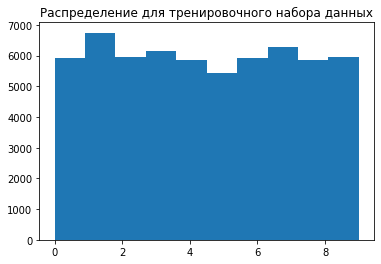

In [9]:
plt.title('Распределение для тренировочного набора данных')
plt.hist(train_data.targets);

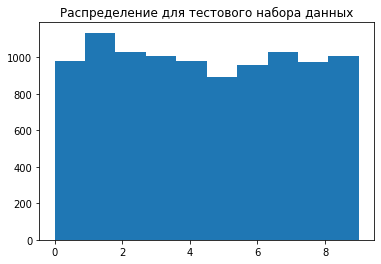

In [10]:
plt.title('Распределение для тестового набора данных')
plt.hist(test_data.targets);

Рассмотрим изображения с рукописными цифрами подробнее. Определим среднее, максимальное и минимальное значения, а также вычислим среднеквадратическое отклонение для тренировочного датасета. Полученные значения можно и нужно использовать для нормализации данных. Для нормализации данных следует использовать функцию transforms.Normalize().

In [11]:
num, height, width = np.array(train_data.data).shape
img_min = np.array(train_data.data).min()
img_max = np.array(train_data.data).max()
img_norm_mean = np.array(train_data.data, dtype=float).mean() / img_max
img_std = np.sqrt(np.sum((np.array(train_data.data) / img_max  - img_norm_mean) ** 2) / (num * height * width))
print(img_min, img_max, img_norm_mean, img_std)

0 255 0.1306604762738429 0.3081078038564622


In [0]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=8, 
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=8, 
                                          shuffle=False)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

tensor([2, 5, 9, 9, 7, 0, 1, 0])


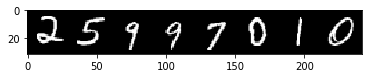

In [13]:
images, labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print(labels)

In [14]:
labels.dtype

torch.int64

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=3, 
                               kernel_size=5, 
                               padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, 
                               out_channels=5, 
                               kernel_size=3, 
                               padding=0)
        self.fc1 = nn.Linear(5 * 22 * 22, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 5 * 22 * 22)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2420, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [0]:
def show_features(features):
    if len(features.shape) < 4:
        for i, feature in enumerate(features):
            plt.subplot(1, num_feature, i+1)
            plt.imshow(feature.numpy().transpose(1,2,0))
    else:
        batch, num_feature = features.shape[:2]
        for i, element in enumerate(features):
            for j, feature in enumerate(element):
                plt.subplot(batch, num_feature, i * num_feature + j + 1)
                plt.imshow(feature.numpy())

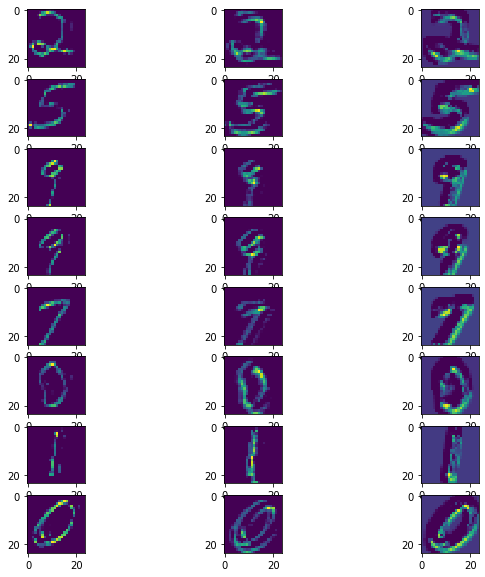

In [18]:
plt.figure(figsize=(10,10))
show_features(net.features_1(images.to(device)).detach().cpu())

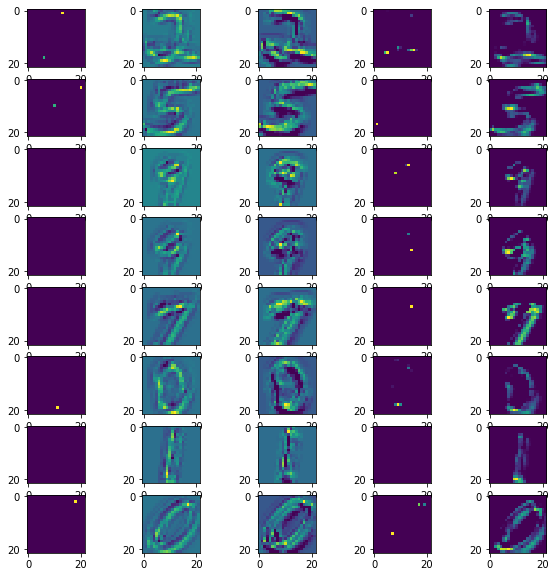

In [19]:
plt.figure(figsize=(10,10))
show_features(net.features_2(images.to(device)).detach().cpu())

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [21]:
from IPython.display import clear_output

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    
#             clear_output()
            print('Epoch %d, step %5d loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

Epoch 1, step  1000 loss: 2.302
Epoch 1, step  2000 loss: 2.293
Epoch 1, step  3000 loss: 2.246
Epoch 1, step  4000 loss: 1.479
Epoch 1, step  5000 loss: 0.487
Epoch 1, step  6000 loss: 0.399
Epoch 1, step  7000 loss: 0.345
Finished Training


In [22]:
labels

tensor([7, 6, 0, 0, 1, 7, 1, 9])

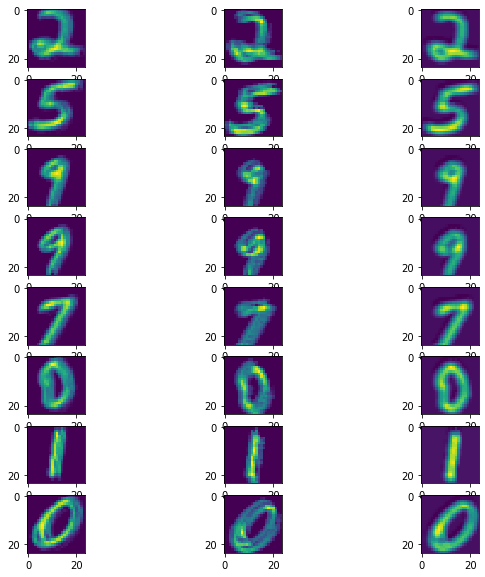

In [23]:
plt.figure(figsize=(10,10))
show_features(net.features_1(images.to(device)).detach().cpu())

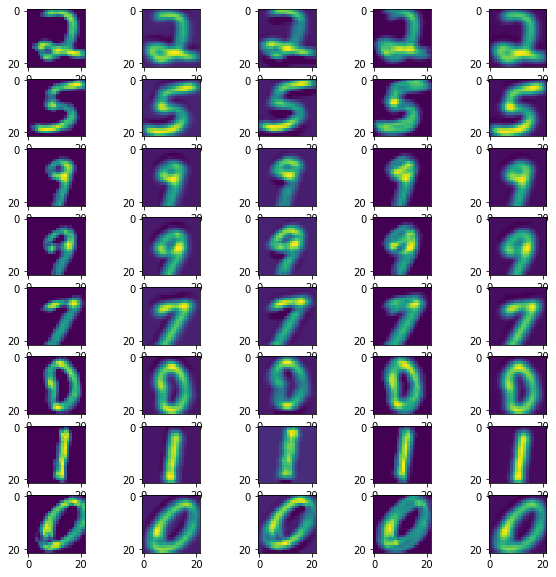

In [24]:
plt.figure(figsize=(10,10))
show_features(net.features_2(images.to(device)).detach().cpu())

GT: tensor([7, 2, 1, 0, 4, 1, 4, 9])
Predict: tensor([7, 2, 1, 0, 4, 1, 4, 9])


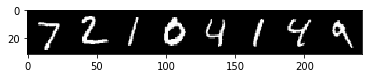

In [25]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# print images
plt.imshow(torchvision.utils.make_grid(images.cpu()).numpy().transpose(1,2,0))
print('GT:', labels)
# imshow(images)
print('Predict:', predicted)

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


добавить/сделать

* LeNet
* Validation
* Validation loss
* Epoch acc.
* Loss curve
* Normalization
* Errors


### LeNet

In [42]:
from collections import OrderedDict

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3),padding=0)),
            ('relu1', nn.ReLU()),
            ('maxpool2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('conv3', nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3))),
            ('relu3', nn.ReLU()),
            ('maxpool4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('conv5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('fc6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('fc7', nn.Linear(84, 10)),
            ('logsoftmax7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(x.size(0), -1)
        output = self.fc(output)
        return output
    
    def features_2(self, x):
        return self.convnet[:5](x)
    
    def features_1(self, x):
        return self.convnet[:3](x)

lenet = LeNet5()
lenet.to(device)

LeNet5(
  (convnet): Sequential(
    (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU()
    (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (fc6): Linear(in_features=120, out_features=84, bias=True)
    (relu6): ReLU()
    (fc7): Linear(in_features=84, out_features=10, bias=True)
    (logsoftmax7): LogSoftmax()
  )
)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=0.0001, momentum=0.9)
x=[]
loss_curve=[]
loss_curve_val=[]

In [44]:
from IPython.display import clear_output

for epoch in range(23):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = lenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:
          validation_loss = 0.
          correct = 0
          total = 0
          with torch.no_grad():
            net.eval()

            for data_val in test_loader:
                inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)

                outputs_val = lenet(inputs_val)
                loss_val = criterion(outputs_val, labels_val)

                validation_loss+=loss_val.item()

                _, predicted = torch.max(outputs_val.data, 1)
                total += labels_val.size(0)
                correct += (predicted == labels_val).sum().item()

            net.train()
            print('epoch %d, step %5d training loss: %.3f validation loss: %.3f test acc: %.3f' %
              (epoch+1, i + 1, running_loss / 1000, validation_loss/1000, 100 * correct / total))
            x.append(len(x))
            loss_curve.append(running_loss/1000)
            loss_curve_val.append(validation_loss/1000)
            running_loss = 0.0

print('Finished Training')

epoch 1, step  1000 training loss: 2.299 validation loss: 2.868 test acc: 20.360
epoch 1, step  2000 training loss: 2.293 validation loss: 2.861 test acc: 21.530
epoch 1, step  3000 training loss: 2.286 validation loss: 2.849 test acc: 23.350
epoch 1, step  4000 training loss: 2.273 validation loss: 2.828 test acc: 30.630
epoch 1, step  5000 training loss: 2.248 validation loss: 2.782 test acc: 37.660
epoch 1, step  6000 training loss: 2.187 validation loss: 2.655 test acc: 40.850
epoch 1, step  7000 training loss: 1.985 validation loss: 2.226 test acc: 52.240
epoch 2, step  1000 training loss: 1.188 validation loss: 1.149 test acc: 74.450
epoch 2, step  2000 training loss: 0.797 validation loss: 0.835 test acc: 80.220
epoch 2, step  3000 training loss: 0.630 validation loss: 0.714 test acc: 82.950
epoch 2, step  4000 training loss: 0.545 validation loss: 0.600 test acc: 85.540
epoch 2, step  5000 training loss: 0.500 validation loss: 0.540 test acc: 87.310
epoch 2, step  6000 training

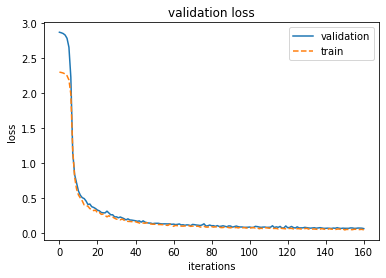

In [45]:
plt.plot(figsize=(12, 4))
plt.plot(x, loss_curve_val, label='validation')
plt.plot(x, loss_curve, '--',label='train')
plt.title('validation loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

GT: tensor([7, 2, 1, 0, 4, 1, 4, 9])
Predict: tensor([7, 2, 1, 0, 4, 1, 4, 9])


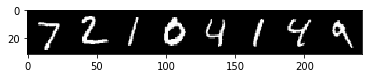

In [46]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = lenet(images)
_, predicted = torch.max(outputs, 1)

plt.imshow(torchvision.utils.make_grid(images.cpu()).numpy().transpose(1,2,0))
print('GT:', labels)
print('Predict:', predicted)

In [84]:
correct = 0
total = 0
errors_images = []
errors_labels = []
errors_predicted = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = lenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        mask = torch.where(predicted != labels)
        errors_images.extend(images[mask])
        errors_labels.extend(labels[mask])
        errors_predicted.extend(predicted[mask])

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [85]:
len(errors_inputs)

158

In [86]:
model = LeNet5()
model.to(device)

LeNet5(
  (convnet): Sequential(
    (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU()
    (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (fc6): Linear(in_features=120, out_features=84, bias=True)
    (relu6): ReLU()
    (fc7): Linear(in_features=84, out_features=10, bias=True)
    (logsoftmax7): LogSoftmax()
  )
)

Predicted:  8 Real label: 9


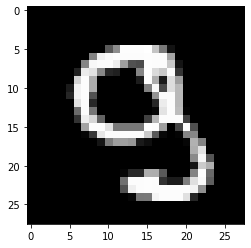

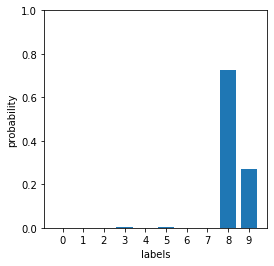

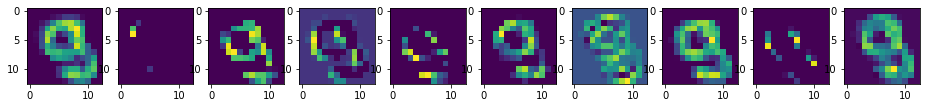

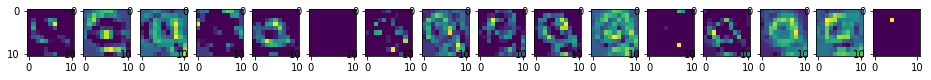

Predicted:  0 Real label: 6


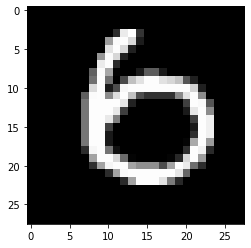

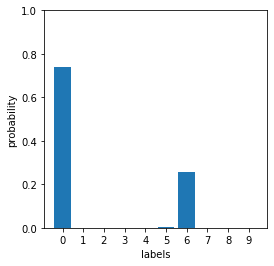

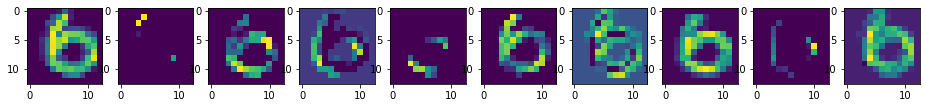

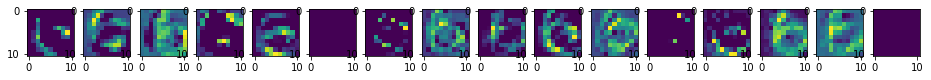

Predicted:  7 Real label: 2


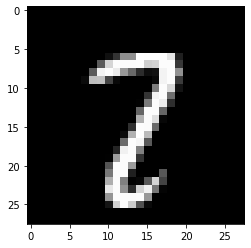

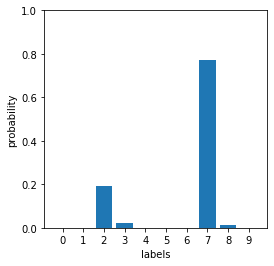

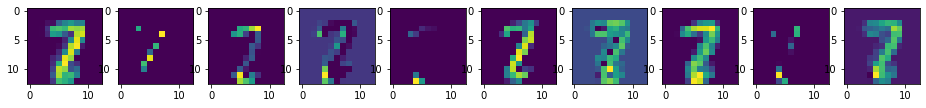

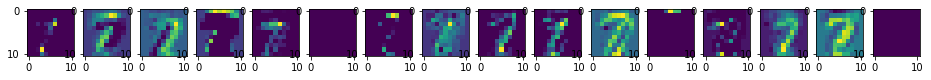

Predicted:  5 Real label: 3


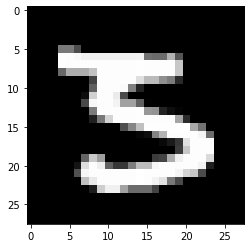

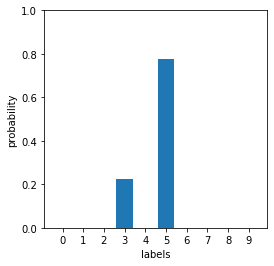

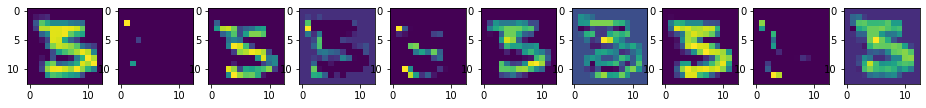

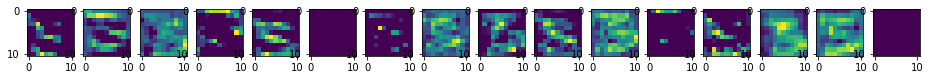

Predicted:  2 Real label: 8


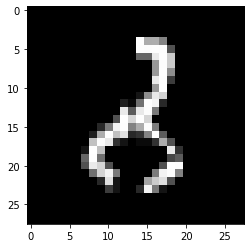

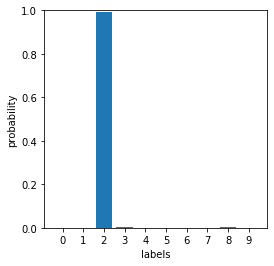

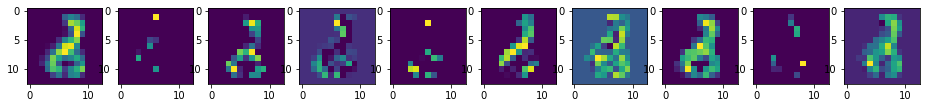

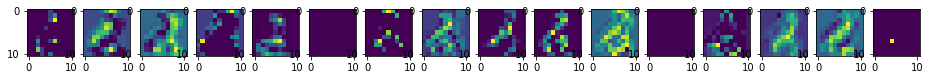

Predicted:  3 Real label: 2


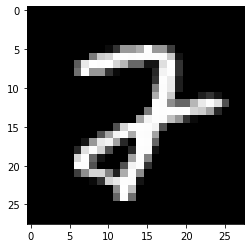

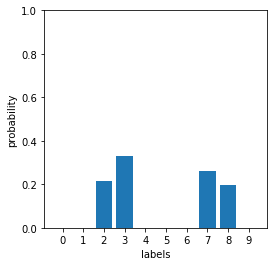

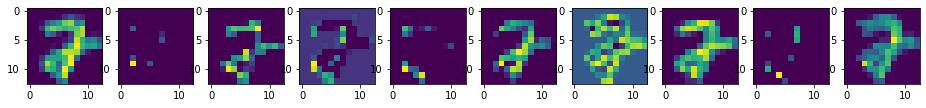

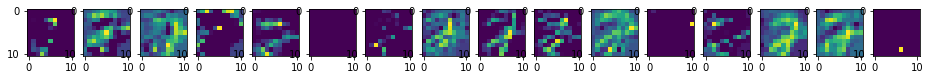

Predicted:  8 Real label: 1


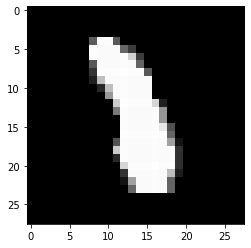

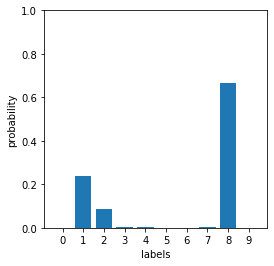

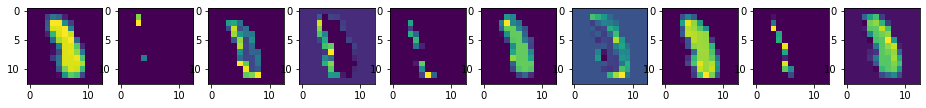

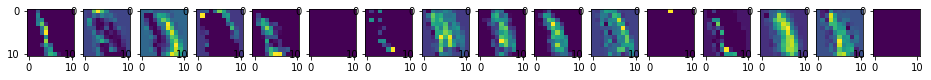

Predicted:  1 Real label: 2


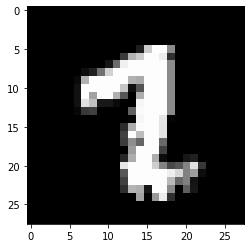

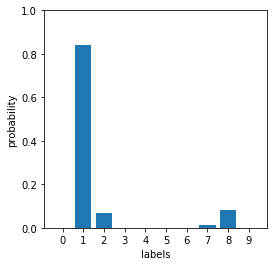

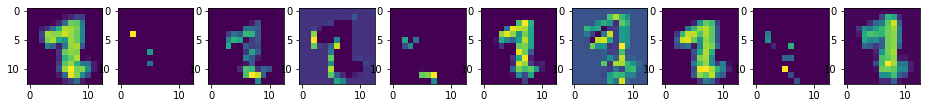

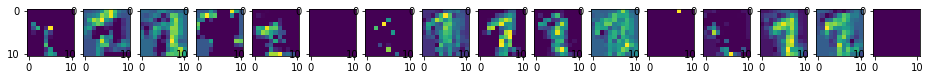

Predicted:  3 Real label: 7


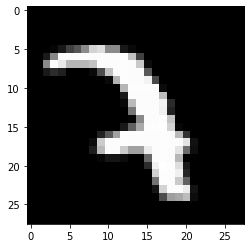

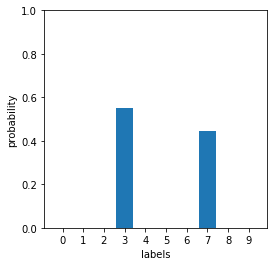

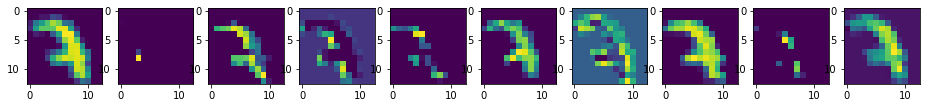

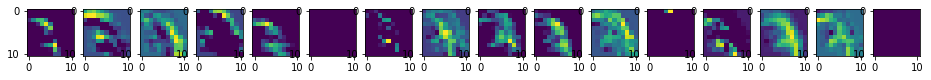

Predicted:  8 Real label: 5


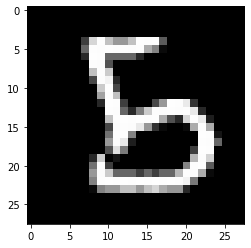

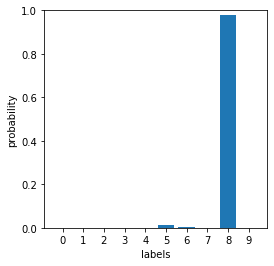

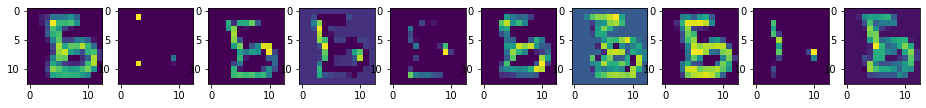

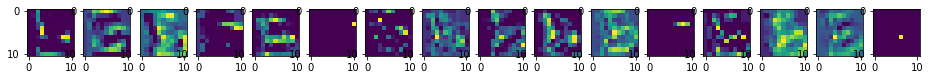

Predicted:  8 Real label: 3


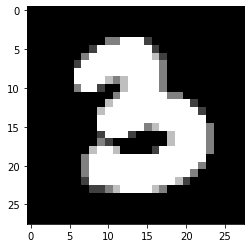

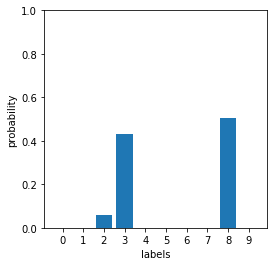

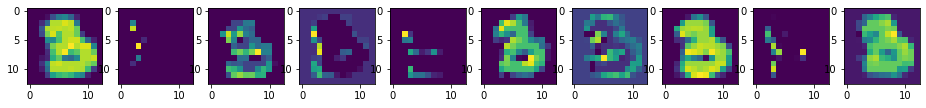

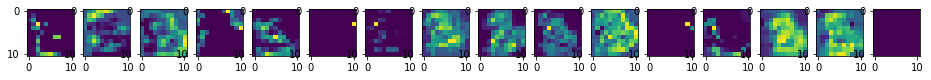

Predicted:  5 Real label: 3


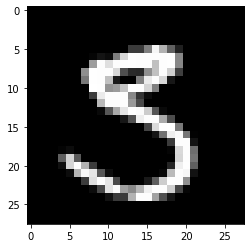

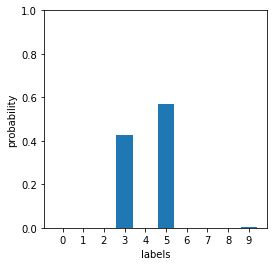

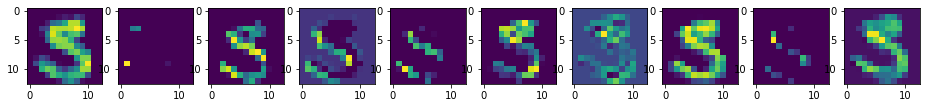

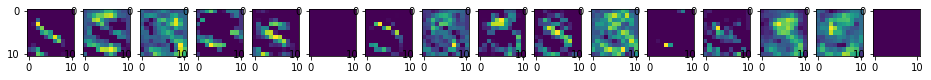

Predicted:  9 Real label: 8


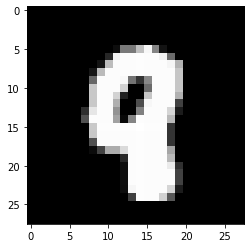

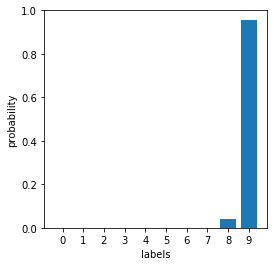

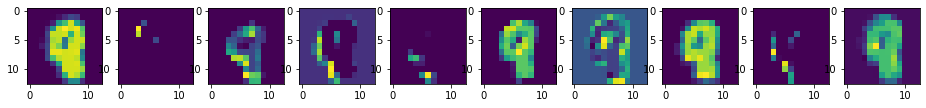

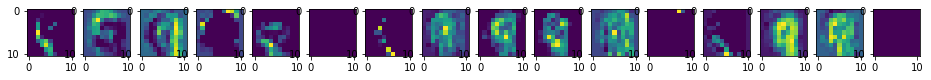

Predicted:  5 Real label: 6


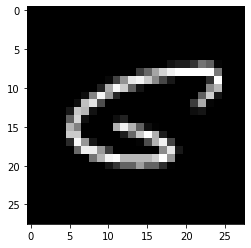

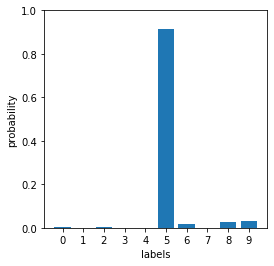

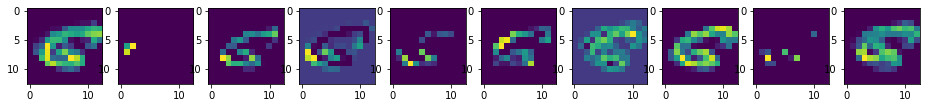

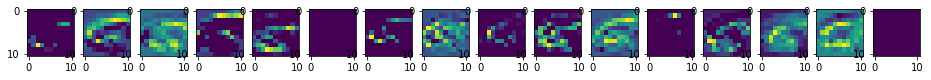

Predicted:  1 Real label: 7


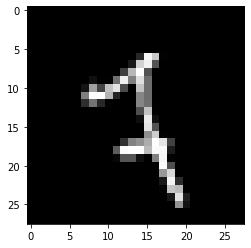

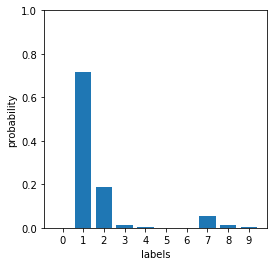

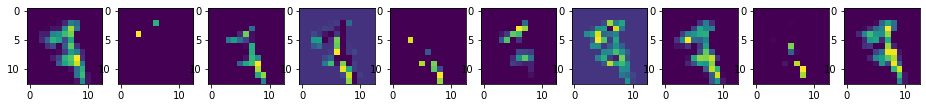

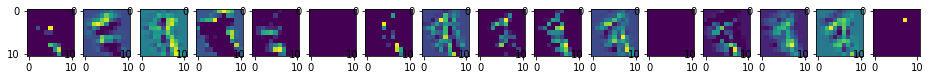

Predicted:  7 Real label: 3


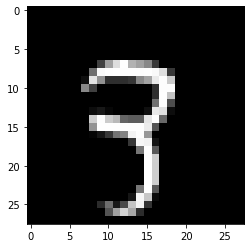

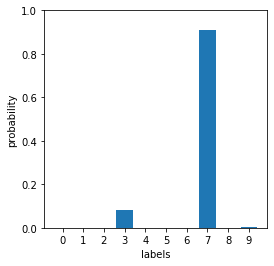

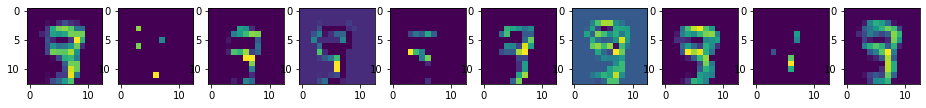

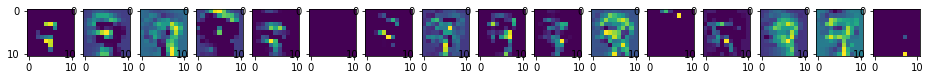

Predicted:  6 Real label: 4


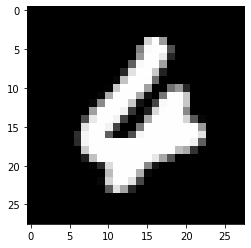

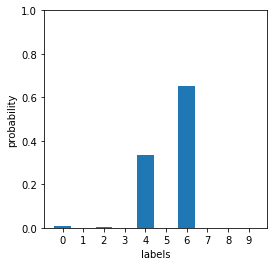

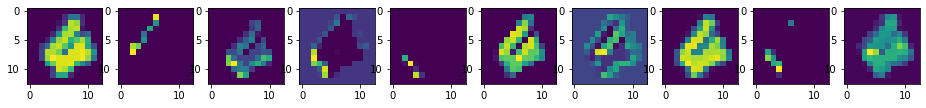

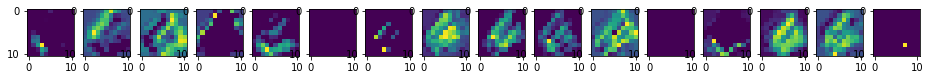

Predicted:  8 Real label: 3


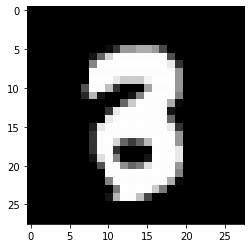

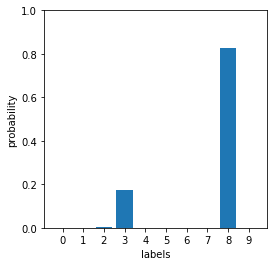

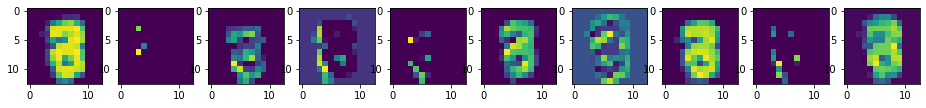

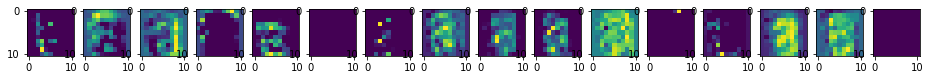

Predicted:  1 Real label: 6


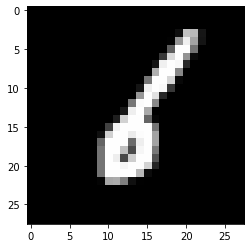

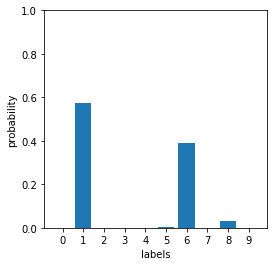

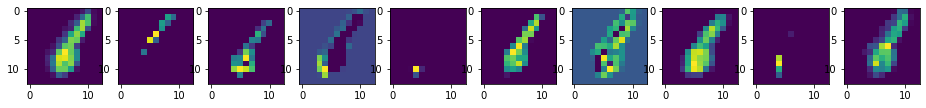

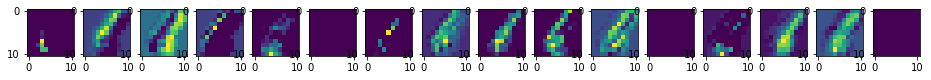

Predicted:  5 Real label: 6


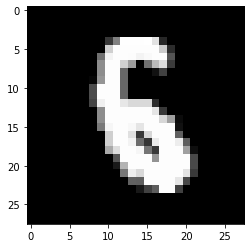

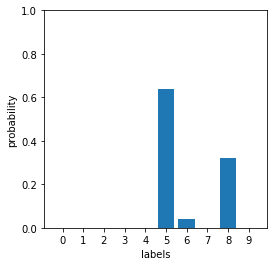

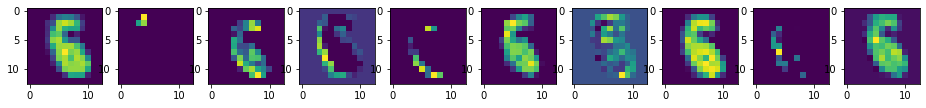

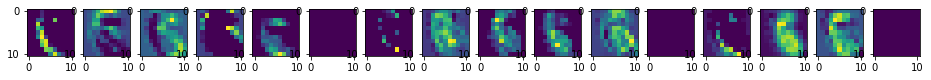

In [92]:
for i in range(20):
    x = np.arange(0, 10, step=1)
    predicted = lenet.forward(errors_images[i].unsqueeze(0))
    predicted=torch.softmax(predicted, dim = 1)
    predicted = predicted.cpu().data.numpy().squeeze()
    
    print("Predicted:  %d Real label: %d" % (errors_predicted[i], errors_labels[i]))
    plt.figure(figsize=(4,4))
    plt.imshow(errors_images[i].resize_(1,28,28).cpu().numpy().squeeze(), cmap = 'gray')
    plt.show()
    
    plt.figure(figsize=(4,4))
    plt.bar(x, predicted)
    plt.xticks(x)
    plt.ylim(0, 1)
    plt.ylabel('probability')
    plt.xlabel('labels')
    plt.show()
    
    plt.figure(figsize=(16,14))
    show_features(model.features_1(errors_images[i].unsqueeze(0).to(device)).detach().cpu())
    plt.show()
    
    plt.figure(figsize=(16,14))
    show_features(model.features_2(errors_images[i].unsqueeze(0).to(device)).detach().cpu())
    plt.show()